#### ARIMA 

- `SARIMAX` (Seasonal Autoregressive Integrated Moving Average Exogenous)
- `Exogenous` variable is more like an external factor or cause impacting the `endogenous` variable.

In [ ]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [ ]:
import itertools
import statsmodels as sm
from statsmodels.tsa import stattools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the locust resampled dataframe
locust_resample_rainfall = pd.read_csv("/content/drive/MyDrive/Hamoye AI labs Projects/Climate Change/Model/locust_resample_rainfall.csv")
locust_resample_rainfall.head()

,STARTDATE,Rainfall_Value,LOCPRESENT
0,1987-01-01,0.663569,2
1,1987-06-01,15.713973,15
2,1987-07-01,141.305729,52
3,1987-08-01,60.957065,13
4,1989-01-01,5.400155,8


In [ ]:
len(locust_resample_rainfall)

36

In [ ]:
# Load the locust Squared transformed dataset
locust_square_transform = pd.read_csv("/content/drive/MyDrive/Hamoye AI labs Projects/Climate Change/Model/locust_square_transform.csv")
locust_square_transform.head()

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust
0,1987-01-01,0.663569,2,1.414214
1,1987-06-01,15.713973,15,3.872983
2,1987-07-01,141.305729,52,7.211103
3,1987-08-01,60.957065,13,3.605551
4,1989-01-01,5.400155,8,2.828427


In [ ]:
# Load the first differenced locust dataset
locust_difference = pd.read_csv("/content/drive/MyDrive/Hamoye AI labs Projects/Climate Change/Model/locust_difference.csv")
locust_difference.head()

,STARTDATE,Rainfall_Value,LOCPRESENT,Square_root_transformed_locust,Locust_First_Difference
0,1987-01-01,0.663569,2,1.414214,NaN
1,1987-06-01,15.713973,15,3.872983,2.458770
2,1987-07-01,141.305729,52,7.211103,3.338119
3,1987-08-01,60.957065,13,3.605551,-3.605551
4,1989-01-01,5.400155,8,2.828427,-0.777124


- Will be using the `locust_square_transform` dataset for the `ARIMA` modeling.

- `FIRST METHOD`

In [ ]:
# Make the datetime index of the dataframe
locust_square_transform.set_index('STARTDATE', inplace=True)

In [ ]:
endo = locust_square_transform['Square_root_transformed_locust']
len(endo)

36

In [ ]:
endo

STARTDATE
1987-01-01     1.414214
1987-06-01     3.872983
1987-07-01     7.211103
1987-08-01     3.605551
1989-01-01     2.828427
2009-06-01     2.645751
2009-07-01     3.000000
2009-08-01     1.732051
2014-03-01     2.449490
2014-04-01     2.828427
2014-05-01     5.916080
2014-08-01     2.236068
2014-10-01     1.414214
2019-06-01     1.732051
2019-08-01     4.582576
2019-09-01     5.830952
2019-10-01     3.872983
2019-11-01     8.062258
2019-12-01     6.782330
2020-01-01     9.327379
2020-02-01    10.198039
2020-03-01     9.899495
2020-04-01    16.673332
2020-05-01     9.797959
2020-06-01    10.630146
2020-07-01     9.380832
2020-08-01    11.135529
2020-09-01    13.638182
2020-10-01    22.271057
2020-11-01     8.831761
2020-12-01    21.000000
2021-01-01    16.733201
2021-02-01    17.406895
2021-03-01     8.888194
2021-04-01    10.198039
2021-05-01     5.099020
Name: Square_root_transformed_locust, dtype: float64

In [ ]:
enxo = locust_square_transform['Rainfall_Value']
len(enxo)

36

In [ ]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 4)
SARIMAX: (0, 0, 1) x (0, 1, 0, 4)
SARIMAX: (0, 1, 0) x (0, 1, 1, 4)
SARIMAX: (0, 1, 0) x (1, 0, 0, 4)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endo, enxo,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False, enforce_stationarity=False)
            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 4)12 - AIC:245.76764003138103
SARIMAX(0, 0, 0)x(0, 0, 1, 4)12 - AIC:206.37031890348578
SARIMAX(0, 0, 0)x(0, 1, 0, 4)12 - AIC:190.37785284759738
SARIMAX(0, 0, 0)x(0, 1, 1, 4)12 - AIC:168.54181130935925
SARIMAX(0, 0, 0)x(1, 0, 0, 4)12 - AIC:196.88470786120638
SARIMAX(0, 0, 0)x(1, 0, 1, 4)12 - AIC:190.06907317236212
SARIMAX(0, 0, 0)x(1, 1, 0, 4)12 - AIC:171.96841938759167
SARIMAX(0, 0, 0)x(1, 1, 1, 4)12 - AIC:168.44846544305565
SARIMAX(0, 0, 0)x(2, 0, 0, 4)12 - AIC:170.29299392789656
SARIMAX(0, 0, 0)x(2, 0, 1, 4)12 - AIC:172.2868559475919
SARIMAX(0, 0, 0)x(2, 1, 0, 4)12 - AIC:151.3120628893413
SARIMAX(0, 0, 0)x(2, 1, 1, 4)12 - AIC:153.1790039923426
SARIMAX(0, 0, 1)x(0, 0, 0, 4)12 - AIC:227.9767502043855
SARIMAX(0, 0, 1)x(0, 0, 1, 4)12 - AIC:193.25907914879417
SARIMAX(0, 0, 1)x(0, 1, 0, 4)12 - AIC:182.81216172353098
SARIMAX(0, 0, 1)x(0, 1, 1, 4)12 - AIC:161.0214072684431
SARIMAX(0, 0, 1)x(1, 0, 0, 4)12 - AIC:193.2566854475955
SARIMAX(0, 0, 1)x(1, 0, 1, 4)12 - AIC

- The above output suggests that `SARIMAX(2, 1, 0)x(2, 1, 0, 4)12`  yields the `lowest AIC` value of `AIC:132.0736131874681`. Therefore we should consider this to be the optimal option.

In [ ]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# (2, 1, 0)x(2, 1, 0, 4)12 - AIC:132.0736131874681

sarimax = SARIMAX(endo,
                    enxo,
                        order=(2,1,0), 
                            seasonal_order=(2,1,0,4),
                                enforce_stationarity=False,
                                    enforce_invertibility=False)
res = sarimax.fit()
print(res.summary().tables[1])

                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Rainfall_Value     0.0033      0.004      0.784      0.433      -0.005       0.011
ar.L1             -0.5501      0.217     -2.537      0.011      -0.975      -0.125
ar.L2              0.0496      0.286      0.173      0.862      -0.511       0.610
ar.S.L4           -0.8825      0.372     -2.375      0.018      -1.611      -0.154
ar.S.L8           -0.1257      0.410     -0.307      0.759      -0.929       0.678
sigma2            18.3673      7.400      2.482      0.013       3.863      32.872


In [ ]:
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     Square_root_transformed_locust   No. Observations:                   36
Model:              SARIMAX(2, 1, 0)x(2, 1, 0, 4)   Log Likelihood                 -60.037
Date:                            Fri, 27 Aug 2021   AIC                            132.074
Time:                                    16:12:13   BIC                            138.341
Sample:                                         0   HQIC                           133.434
                                             - 36                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Rainfall_Value     0.0033      0.004      0.784      0.433      -0.005       0.011
ar.L1             -0.55

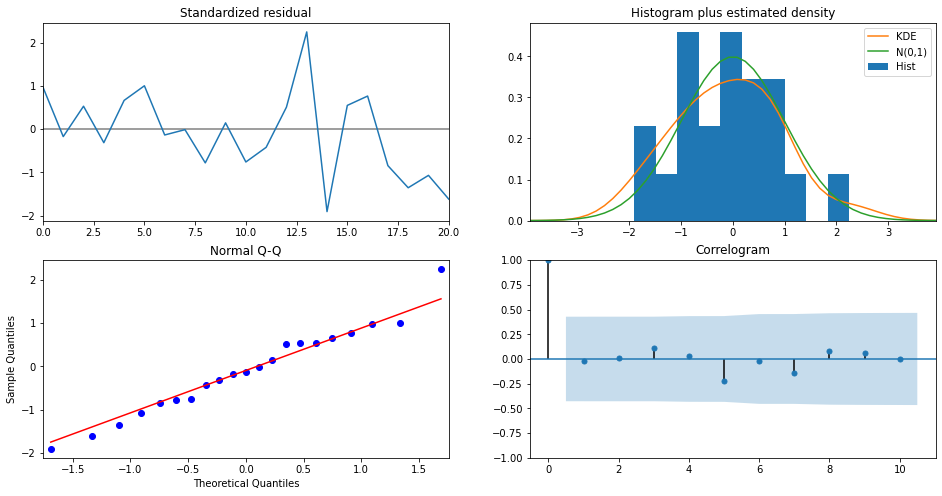

In [ ]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

- It is not perfect, however, our model diagnostics suggests that the model residuals are near `normally distributed`.

- `Validating forecasts`

In [ ]:
locust_square_transform['Square_root_transformed_locust']

STARTDATE
1987-01-01     1.414214
1987-06-01     3.872983
1987-07-01     7.211103
1987-08-01     3.605551
1989-01-01     2.828427
2009-06-01     2.645751
2009-07-01     3.000000
2009-08-01     1.732051
2014-03-01     2.449490
2014-04-01     2.828427
2014-05-01     5.916080
2014-08-01     2.236068
2014-10-01     1.414214
2019-06-01     1.732051
2019-08-01     4.582576
2019-09-01     5.830952
2019-10-01     3.872983
2019-11-01     8.062258
2019-12-01     6.782330
2020-01-01     9.327379
2020-02-01    10.198039
2020-03-01     9.899495
2020-04-01    16.673332
2020-05-01     9.797959
2020-06-01    10.630146
2020-07-01     9.380832
2020-08-01    11.135529
2020-09-01    13.638182
2020-10-01    22.271057
2020-11-01     8.831761
2020-12-01    21.000000
2021-01-01    16.733201
2021-02-01    17.406895
2021-03-01     8.888194
2021-04-01    10.198039
2021-05-01     5.099020
Name: Square_root_transformed_locust, dtype: float64

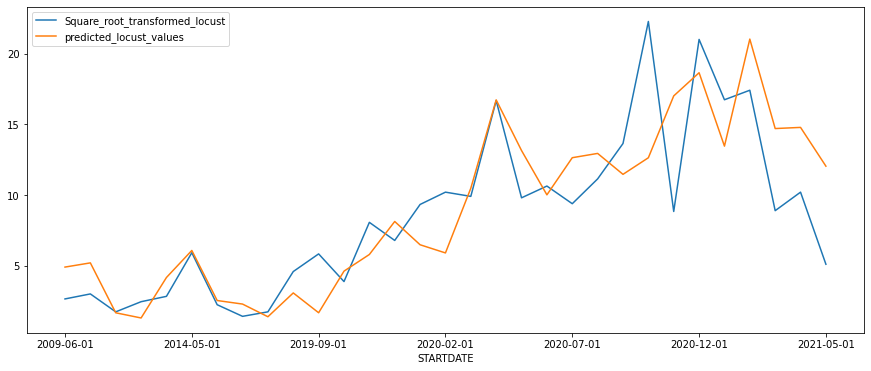

In [ ]:
# include tail in-sample data to highlight how forecast goes wrong
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)

pred_locust = res.predict('2009-06-01', '2021-05-01', exog=enxo.values.reshape((-1, 1)))
pred_locust.name = 'predicted_locust_values'

comp_both = pd.concat((locust_square_transform['Square_root_transformed_locust'].loc['2009-06-01':], pred_locust), axis=1)
comp_both.plot()

In [ ]:
locust_resample_rainfall.head()

,STARTDATE,Rainfall_Value,LOCPRESENT
0,1987-01-01,0.663569,2
1,1987-06-01,15.713973,15
2,1987-07-01,141.305729,52
3,1987-08-01,60.957065,13
4,1989-01-01,5.400155,8


In [ ]:
# Transform the Square-root values as well as the predicted values

- Mean Squared Error and Root Mean Squared Error.

In [ ]:
pred = res.get_prediction(start=('2009-06-01'), dynamic=False)
y_forecasted = pred.predicted_mean
y_truth = endo['2009-06-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 12.59


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3.55


- In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

- Root mean squared error (RMSE) is the square root of the mean of the square of all of the error. The use of RMSE is very common, and it is considered an excellent general-purpose error metric for numerical predictions.

- Make Future Forecast

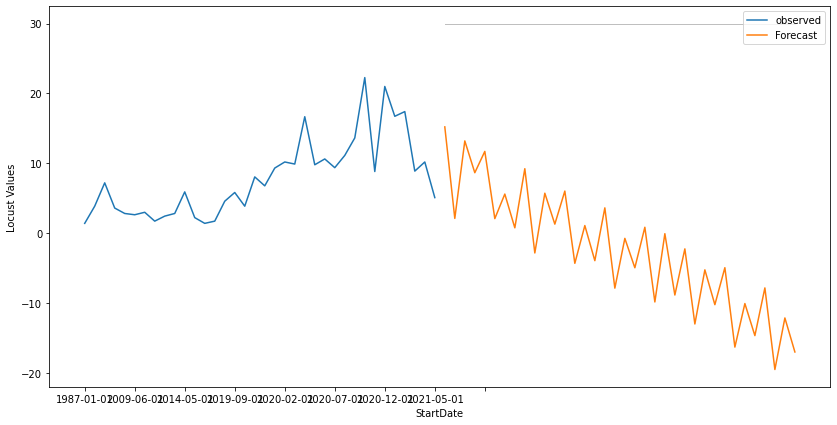

In [ ]:
pred_uc = res.get_forecast(steps=endo.size, exog=enxo.values.reshape((-1, 1)))
pred_ci = pred_uc.conf_int()

ax = endo.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                    30, 30, 
                        color='k', 
                            alpha=.25)

ax.set_xlabel('StartDate')
ax.set_ylabel('Locust Values')
plt.legend()
plt.show()

- `Our model clearly captured Locust infeastation seasonality`. 

- As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future. `(Note: This conclusion is not certain, Just an assumption)`.

            Square_root_transformed_locust  pred_out
1987-01-01                        1.414214       NaN
1987-06-01                        3.872983       NaN
1987-07-01                        7.211103       NaN
1987-08-01                        3.605551       NaN
1989-01-01                        2.828427       NaN


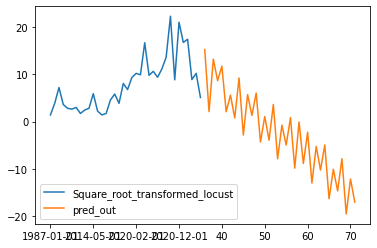

In [ ]:
# out-of-sample prediction starts 2017-10

pred_out = res.forecast(endo.size, exog=enxo.values.reshape((-1, 1)))
pred_out.name = 'pred_out'

comp_out = pd.concat((endo, pred_out), axis=1)

print(comp_out.head())  # indexes line up correctly
comp_out.plot()

In [ ]:
pred0 = res.get_prediction(start=28, dynamic=False)
pred0_ci = pred0.conf_int()
pred0_ci

,lower Square_root_transformed_locust,upper Square_root_transformed_locust
STARTDATE,,
2020-10-01,4.231616,21.031270
2020-11-01,8.605278,25.404932
2020-12-01,10.245729,27.045383
2021-01-01,5.053090,21.852743
2021-02-01,12.624386,29.424040
2021-03-01,6.296971,23.096625
2021-04-01,6.378301,23.177954
2021-05-01,3.636520,20.436174


- `SECOND METHOD`

- Divide data into `train/test`, `80%` for `training` and `20%` for `testing`.

In [ ]:
# endog = locust_resample_rainfall['Square_root_transformed_locust']
# exog = locust_resample_rainfall['Rainfall_Value']

# Get the endogenous and exogenous varaibles
# Divide into train/test

endog_train = locust_resample_rainfall['Square_root_transformed_locust'].loc[:28]  # '2020-09-01'
endog_test = locust_resample_rainfall['Square_root_transformed_locust'].loc[28:]   # '2020-09-02'

exog_train = locust_resample_rainfall['Rainfall_Value'].loc[:28] # '2020-09-01'   
exog_test = locust_resample_rainfall['Rainfall_Value'].loc[28:]   # '2020-09-02'

print("Shape of endogenous training data is {}, and shape of endogenous testing data is {}" .format(endog_train.shape, endog_test.shape))
print("Shape of endogenous training data is {}, and shape of endogenous testing data is {}" .format(exog_train.shape, exog_test.shape))

In [ ]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

-  This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a `“grid search”` to find the optimal set of parameters that yields the best performance for our model.

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(endog_train, exog_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False, enforce_stationarity=False)
            results = mod.fit()
            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

- The above output suggests that `SARIMAX(0, 0, 0)x(0, 0, 0, 3)` yields the lowest `AIC` value of `000.00`. Therefore we should consider this to be optimal option.

In [ ]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# try SARIMAX(2,0,1)(0,1,1,12)
# (1, 2, 2)x(2, 2, 0, 6) fine
# (0, 2, 2)x(2, 2, 0, 6)
# (0, 1, 2)x(2, 2, 0, 6)

sarimax = SARIMAX(endog=endog_train, 
                    exog=exog_train,
                        order=(2,0,2), 
                            seasonal_order=(2,2,0,6),
                                enforce_stationarity=False,
                                    enforce_invertibility=False)
res = sarimax.fit()
print(res.summary().tables[1])

In [ ]:
print(res.summary())

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# setting initial values and some bounds for them
ps = range(0, 2)
d=0
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 4 # season length

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table